In [12]:
from qiskit_aer import AerSimulator
from qiskit import *
import supermarq
from qiskit.providers.fake_provider import *
import numpy as np 
import os

########## INPUT ############
f=5 # number of fake_backend want to choose
lower_limit= 3 # the lower limit of qubits for the circuit
upper_limit= 5 # the lower limit of qubits for the circuit
steps= 1 #jump in qubit numbers
name_of_algo='hamiltonian'

In [13]:
all_fakes=[FakeAlmadenV2,FakeArmonkV2,FakeAthensV2,FakeAuckland,FakeBelemV2,FakeBoeblingenV2,FakeBogotaV2,FakeBrooklynV2,FakeBurlingtonV2,FakeCairoV2,FakeCambridgeV2,FakeCasablancaV2,FakeEssexV2,FakeGeneva,FakeGuadalupeV2,FakeHanoiV2,FakeJakartaV2,FakeJohannesburgV2,FakeKolkataV2,FakeLagosV2,FakeLimaV2,FakeLondonV2,FakeManhattanV2,FakeManilaV2,FakeMelbourneV2,FakeMontrealV2,FakeMumbaiV2,FakeNairobiV2,FakeOslo,FakeOurenseV2,FakeParisV2,FakePerth,FakePrague,FakePoughkeepsieV2,FakeQuitoV2,FakeRochesterV2,FakeRomeV2,FakeSantiagoV2,FakeSherbrooke,FakeSingaporeV2,FakeSydneyV2,FakeTorontoV2,FakeValenciaV2,FakeVigoV2,FakeWashingtonV2,FakeYorktownV2]
import random; selected_fakes = random.sample(all_fakes, f)
selected_fakes  # having any randomly selected 5 fake backends out of 46 mentioned in the inital list

[qiskit.providers.fake_provider.backends.casablanca.fake_casablanca.FakeCasablancaV2,
 qiskit.providers.fake_provider.backends.singapore.fake_singapore.FakeSingaporeV2,
 qiskit.providers.fake_provider.backends.oslo.fake_oslo.FakeOslo,
 qiskit.providers.fake_provider.backends.toronto.fake_toronto.FakeTorontoV2,
 qiskit.providers.fake_provider.backends.lima.fake_lima.FakeLimaV2]

In [14]:
benchmarks=[]
for i in range(lower_limit,upper_limit,steps):
    label = name_of_algo+str(i)
    benchmarks.append((supermarq.hamiltonian_simulation.HamiltonianSimulation(i),label))
for i in benchmarks:
    circuit=i[0].qiskit_circuit()
    print("--------------------------",i[1],"---------------------------")
    #circuit.draw(output="mpl")
    print(circuit.draw())

-------------------------- hamiltonian3 ---------------------------
     ┌───┐┌───────────┐┌───┐                           ┌─┐                    »
q_0: ┤ H ├┤ Rz(-3π/4) ├┤ H ├──■────────────────■───────┤M├────────────────────»
     ├───┤├───────────┤├───┤┌─┴─┐┌──────────┐┌─┴─┐     └╥┘                 ┌─┐»
q_1: ┤ H ├┤ Rz(-3π/4) ├┤ H ├┤ X ├┤ Rz(-π/2) ├┤ X ├──■───╫───────────────■──┤M├»
     ├───┤├───────────┤├───┤└───┘└──────────┘└───┘┌─┴─┐ ║ ┌──────────┐┌─┴─┐└╥┘»
q_2: ┤ H ├┤ Rz(-3π/4) ├┤ H ├──────────────────────┤ X ├─╫─┤ Rz(-π/2) ├┤ X ├─╫─»
     └───┘└───────────┘└───┘                      └───┘ ║ └──────────┘└───┘ ║ »
c: 3/═══════════════════════════════════════════════════╩═══════════════════╩═»
                                                        0                   1 »
«        
«q_0: ───
«        
«q_1: ───
«     ┌─┐
«q_2: ┤M├
«     └╥┘
«c: 3/═╩═
«      2 
-------------------------- hamiltonian4 ---------------------------
     ┌───┐┌───────────┐┌───┐                          

In [15]:
benchmark_features = {}
for benchmark, label in benchmarks:
    benchmark_features[label] = [
        supermarq.converters.compute_communication_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_depth_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_entanglement_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_liveness_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_measurement_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_parallelism_with_qiskit(benchmark.qiskit_circuit()),]
print(benchmark_features)

{'hamiltonian3': [0.6666666666666666, 1.0, 0.26666666666666666, 0.7333333333333333, 0.0, 0.25], 'hamiltonian4': [0.5, 1.0, 0.2857142857142857, 0.5961538461538461, 0.0, 0.20512820512820515]}


In [24]:
%time
import time
jobs =[]
print("=============SCORES OF ALL THE CIRCUITS=============")    
for backend in selected_fakes:
    print("BACKEND-NAME :: ", backend().name)
    for benchmark, label in benchmarks:
        circuit=benchmark.qiskit_circuit()
        score_list=[]
        manual=[]
        timetaken=[]
        for i in range(0,5):
            start = time.time()
            job = backend().run(circuit, shots=1000)
            t_time = time.time()-start
            result = job.result()
            counts = job.result(0).get_counts()
            score = benchmark.score(counts)
            score_list.append(score)
            t=job.result(0).time_taken
            timetaken.append(t)
            manual.append(t_time)
            print(i+1,"th iteration::  Manual::",t_time, " &    Metadata::",t)
        mean_manual_time = np.mean(manual)
        score = np.mean(score_list) 
        sd = np.std(score_list)
        execution_time = np.mean(timetaken)
        print("                      Average of  Manual time taken ::",mean_manual_time)
        print("                      Average of Metadata-wise time taken ::",execution_time)
        print(label, "--> score::",score,"      SD ::",sd)
        jobs.append((label,benchmark,backend,job,score,sd))
#jobs

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 13.4 µs
=============SCORES OF ALL THE CIRCUITS=============
BACKEND-NAME ::  fake_casablanca
1 th iteration::  Manual:: 0.5245285034179688  &    Metadata:: 0.13947629928588867
2 th iteration::  Manual:: 0.381619930267334  &    Metadata:: 0.12935638427734375
3 th iteration::  Manual:: 0.5420615673065186  &    Metadata:: 0.1568450927734375
4 th iteration::  Manual:: 0.3976564407348633  &    Metadata:: 0.3207416534423828
5 th iteration::  Manual:: 0.36640071868896484  &    Metadata:: 0.13312077522277832
                      Average of  Manual time taken :: 0.44245343208312987
                      Average of Metadata-wise time taken :: 0.17590804100036622
hamiltonian3 --> score:: 0.9525132760733926       SD :: 0.0043532873912838985
1 th iteration::  Manual:: 0.5658903121948242  &    Metadata:: 0.1411268711090088
2 th iteration::  Manual:: 0.40189623832702637  &    Metadata:: 0.12829804420471191
3 th iteration::  Manual:: 0.56466102

In [17]:
all_scores={}  
all_fake_names=[]
all_fake_scores=[]
for i in selected_fakes:
    fakes=i
    #print("SELCETED_FAKES:: ",i)
    i={}
    for label,benchmark,backend,job,score,sd in jobs:
        #supermarq.plotting.plot_results([score], [label])
        if fakes == backend:
            i[label] = score
    device_scores = 'device_score_' +str(fakes().name)
    all_scores[device_scores]= i
    all_fake_scores.append(i)
    all_fake_names.append(device_scores)   
#print(all_scores)    

USED BACKEND:: fake_casablanca ; CIRCUIT_NAME: hamiltonian3 ; SCORE = 0.9557799427400593


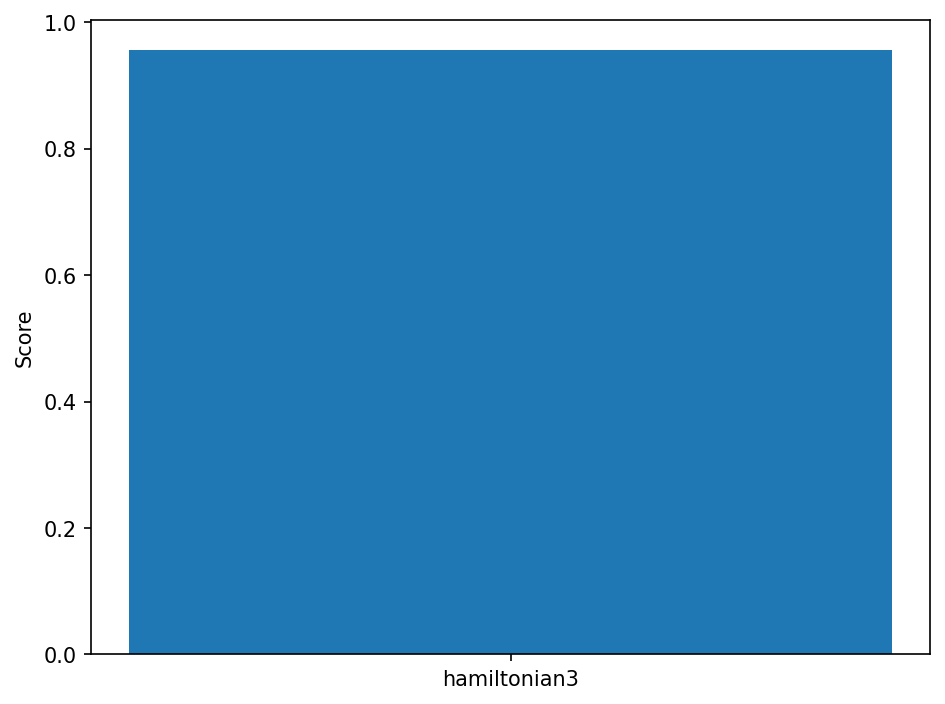

-----------------------------------------------------------
USED BACKEND:: fake_casablanca ; CIRCUIT_NAME: hamiltonian4 ; SCORE = 0.9657466094067259


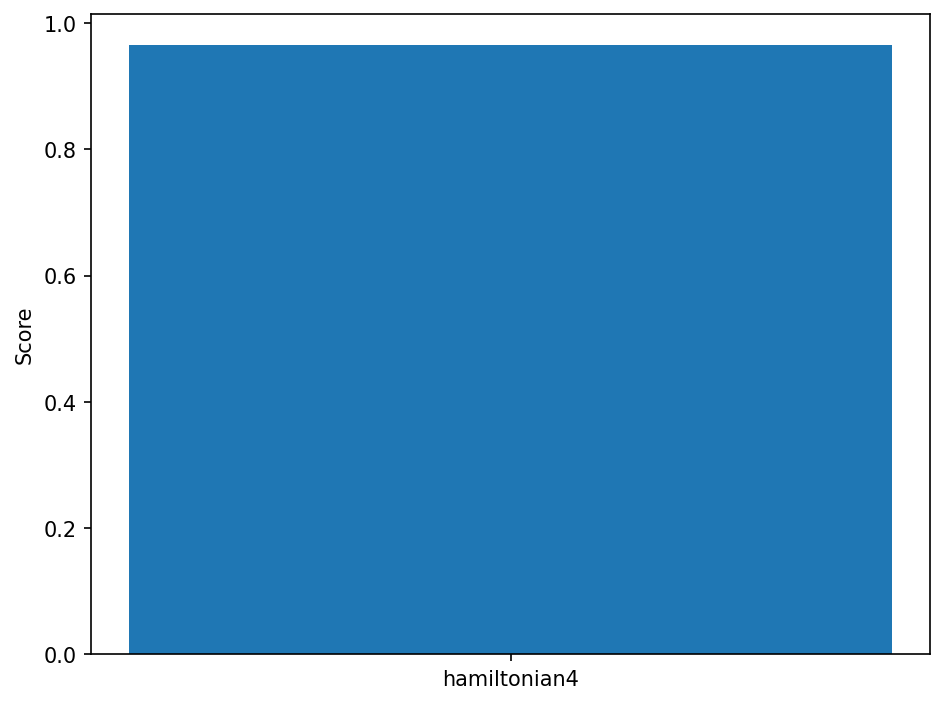

-----------------------------------------------------------
USED BACKEND:: fake_singapore ; CIRCUIT_NAME: hamiltonian3 ; SCORE = 0.9311132760733927


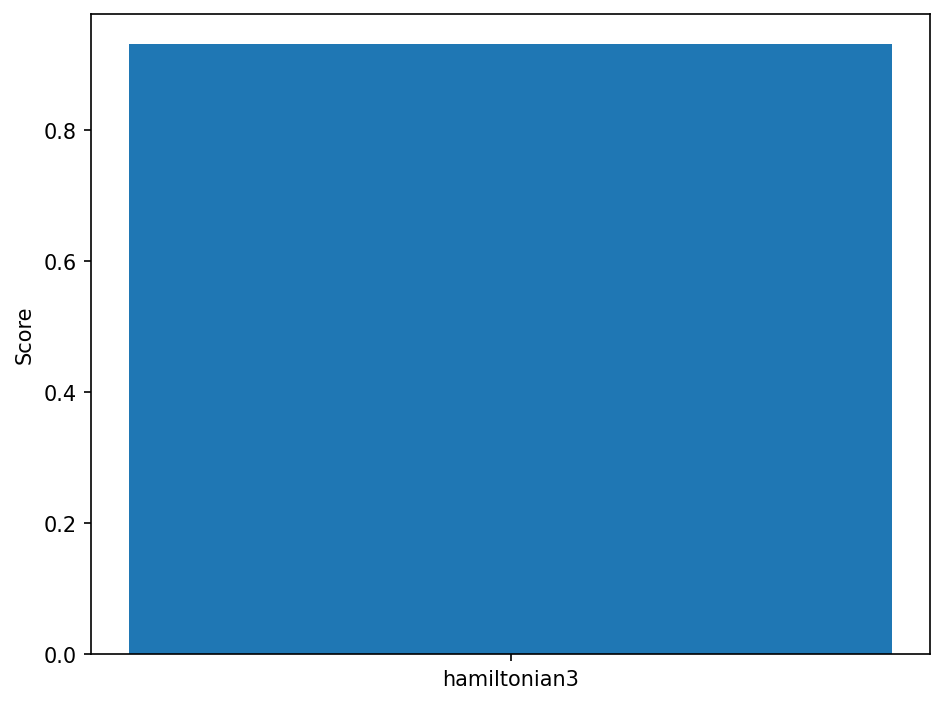

-----------------------------------------------------------
USED BACKEND:: fake_singapore ; CIRCUIT_NAME: hamiltonian4 ; SCORE = 0.9250466094067258


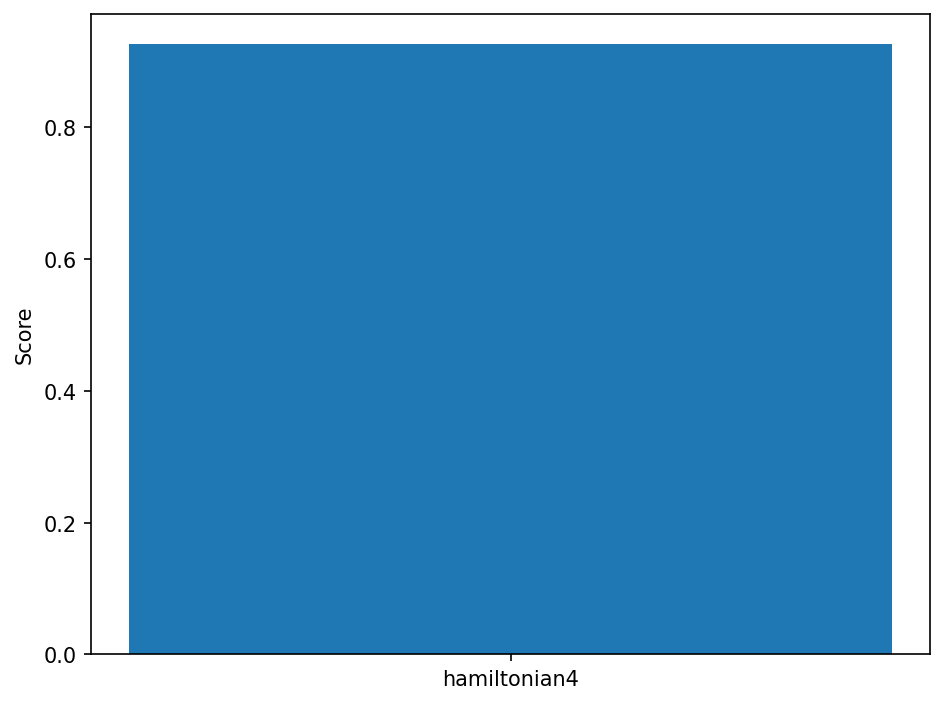

-----------------------------------------------------------
USED BACKEND:: fake_oslo ; CIRCUIT_NAME: hamiltonian3 ; SCORE = 0.9845132760733926


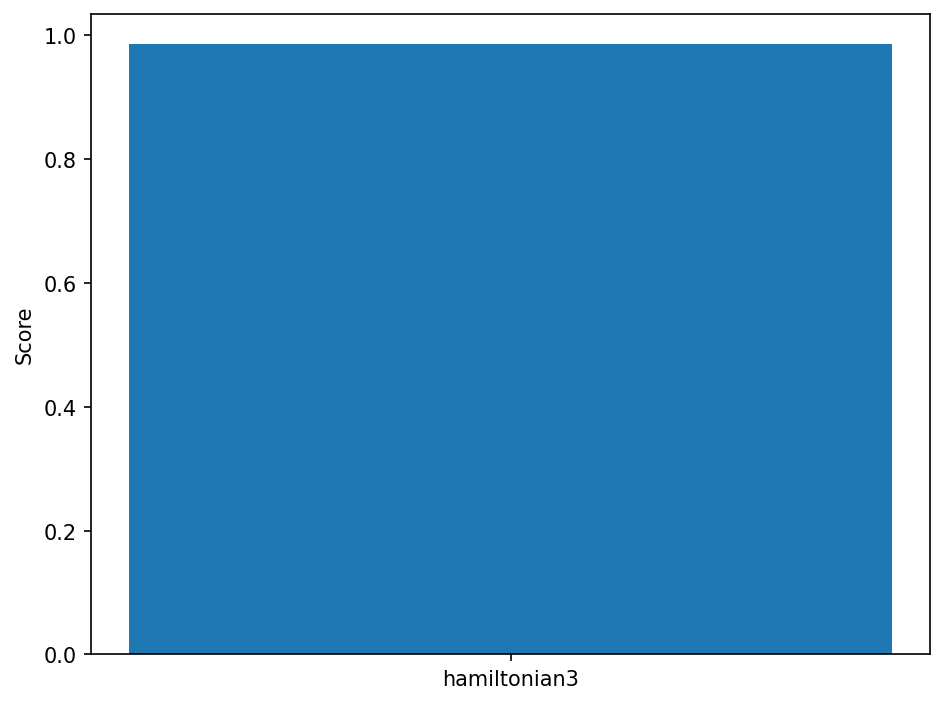

-----------------------------------------------------------
USED BACKEND:: fake_oslo ; CIRCUIT_NAME: hamiltonian4 ; SCORE = 0.9874466094067259


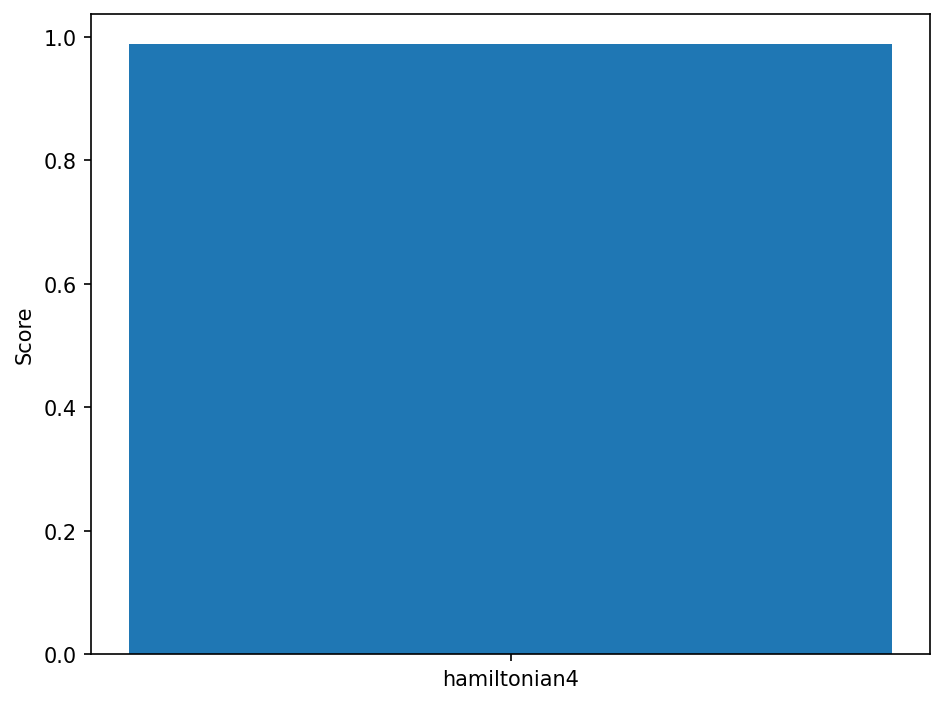

-----------------------------------------------------------
USED BACKEND:: fake_toronto ; CIRCUIT_NAME: hamiltonian3 ; SCORE = 0.8513799427400593


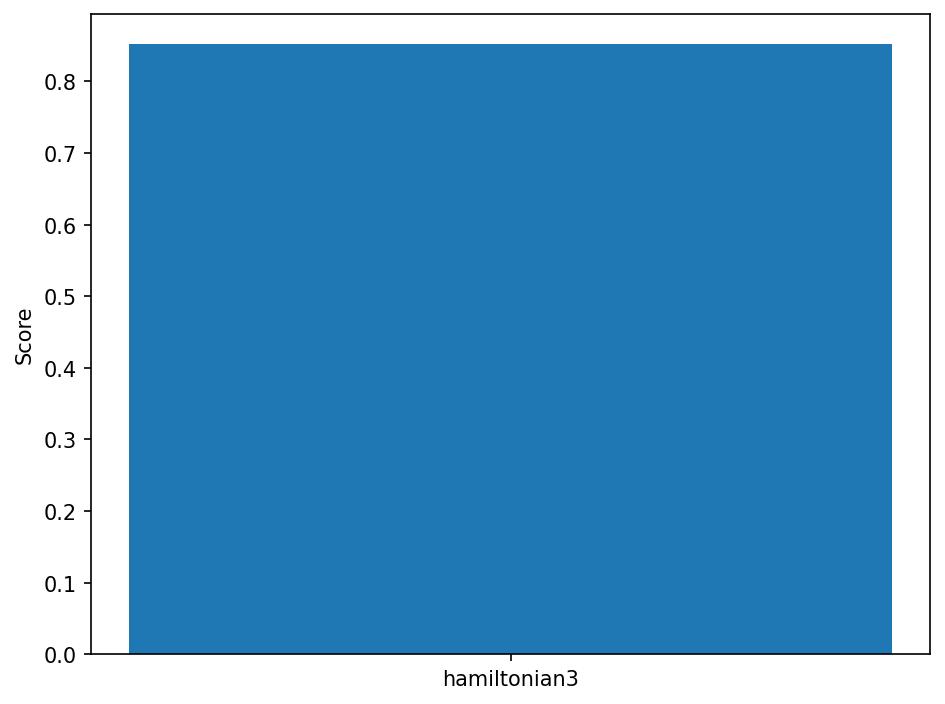

-----------------------------------------------------------
USED BACKEND:: fake_toronto ; CIRCUIT_NAME: hamiltonian4 ; SCORE = 0.8444966094067258


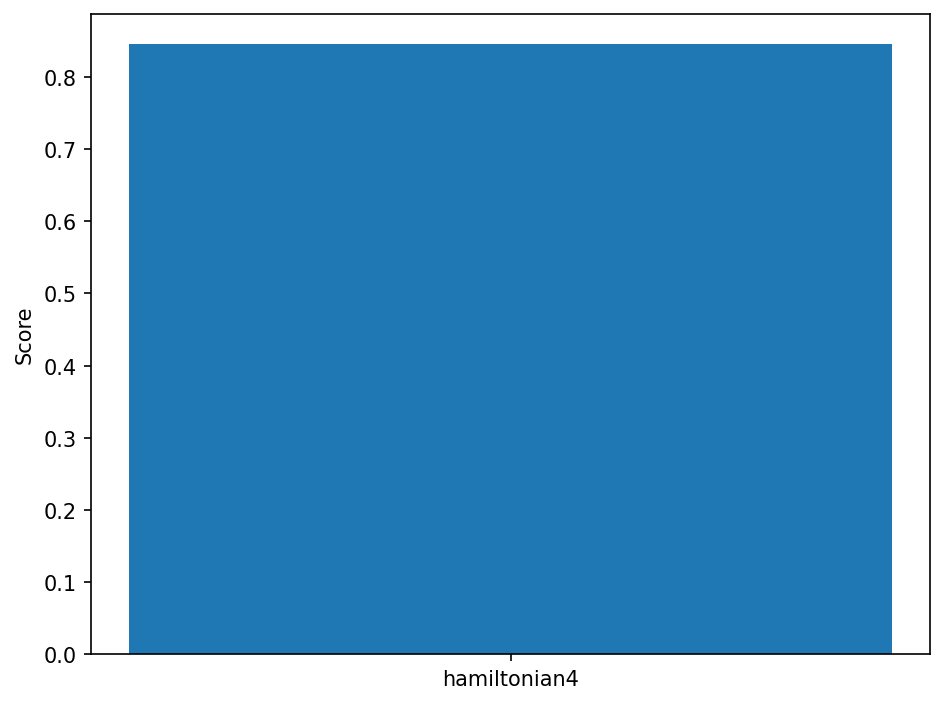

-----------------------------------------------------------
USED BACKEND:: fake_lima ; CIRCUIT_NAME: hamiltonian3 ; SCORE = 0.9572466094067259


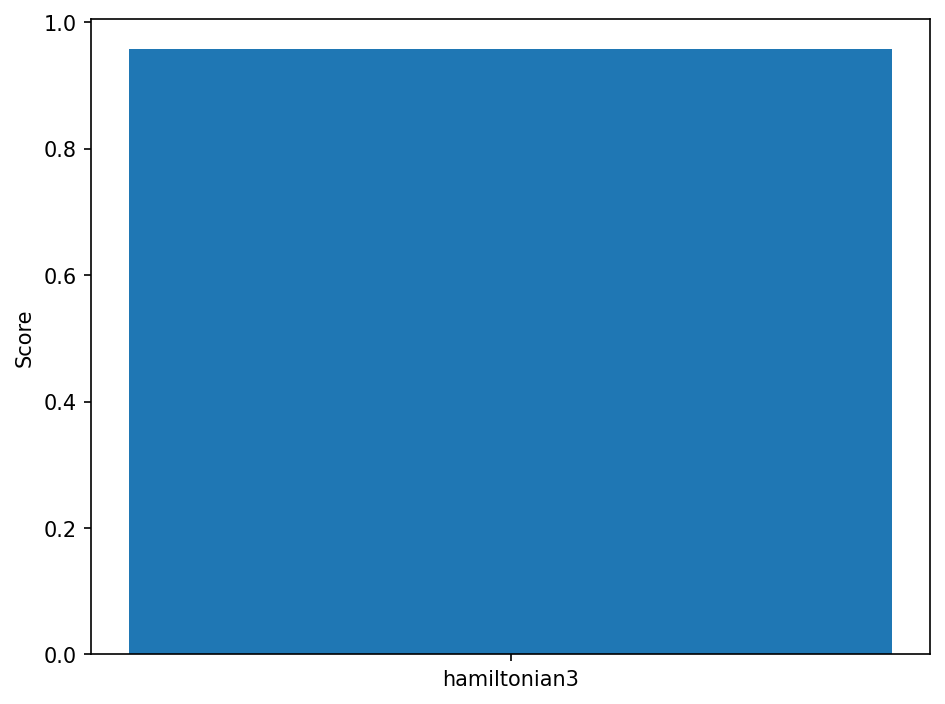

-----------------------------------------------------------
USED BACKEND:: fake_lima ; CIRCUIT_NAME: hamiltonian4 ; SCORE = 0.9582966094067258


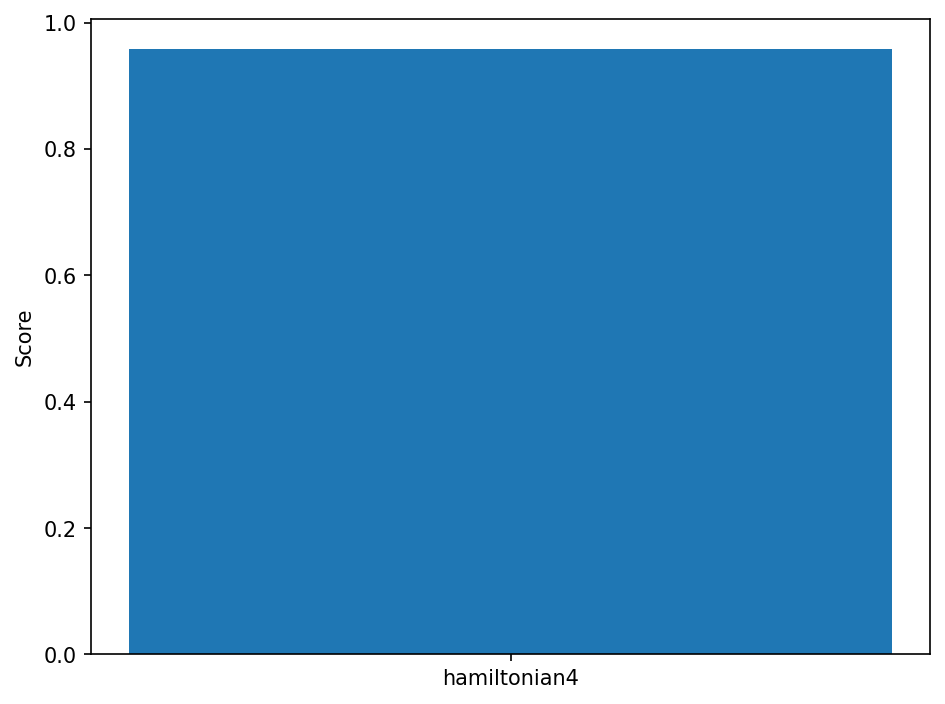

-----------------------------------------------------------


In [18]:
for label,benchmark,backend,job,score,sd in jobs:
    print("USED BACKEND::",backend().name,"; CIRCUIT_NAME:",label, "; SCORE =",score)
    supermarq.plotting.plot_results([score], [label])
    print("-----------------------------------------------------------")

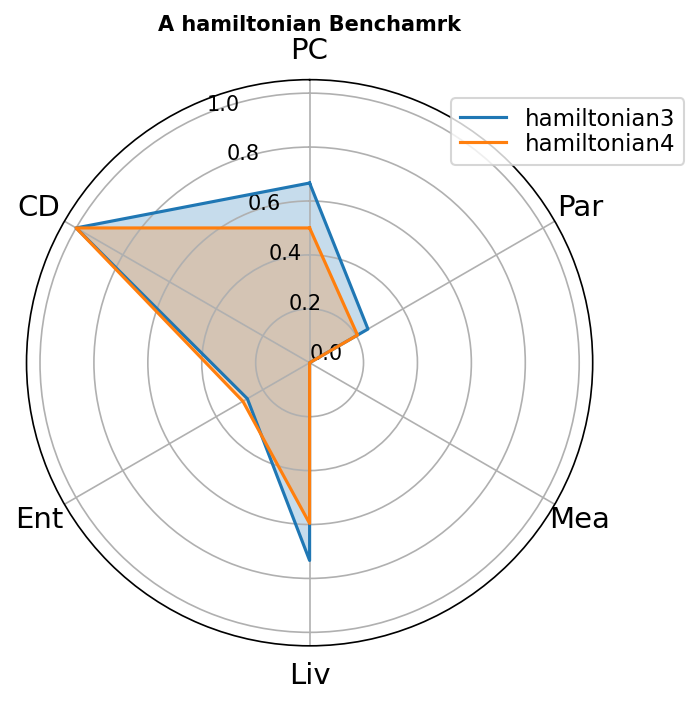

In [19]:
names=[]
scores=[]
X="A "+name_of_algo+' Benchamrk'
for i,j in benchmark_features.items():
    names.append(i)
    scores.append(j)
supermarq.plotting.plot_benchmark([X,names,scores],
        spoke_labels=["PC", "CD", "Ent", "Liv", "Mea", "Par"],show=True)

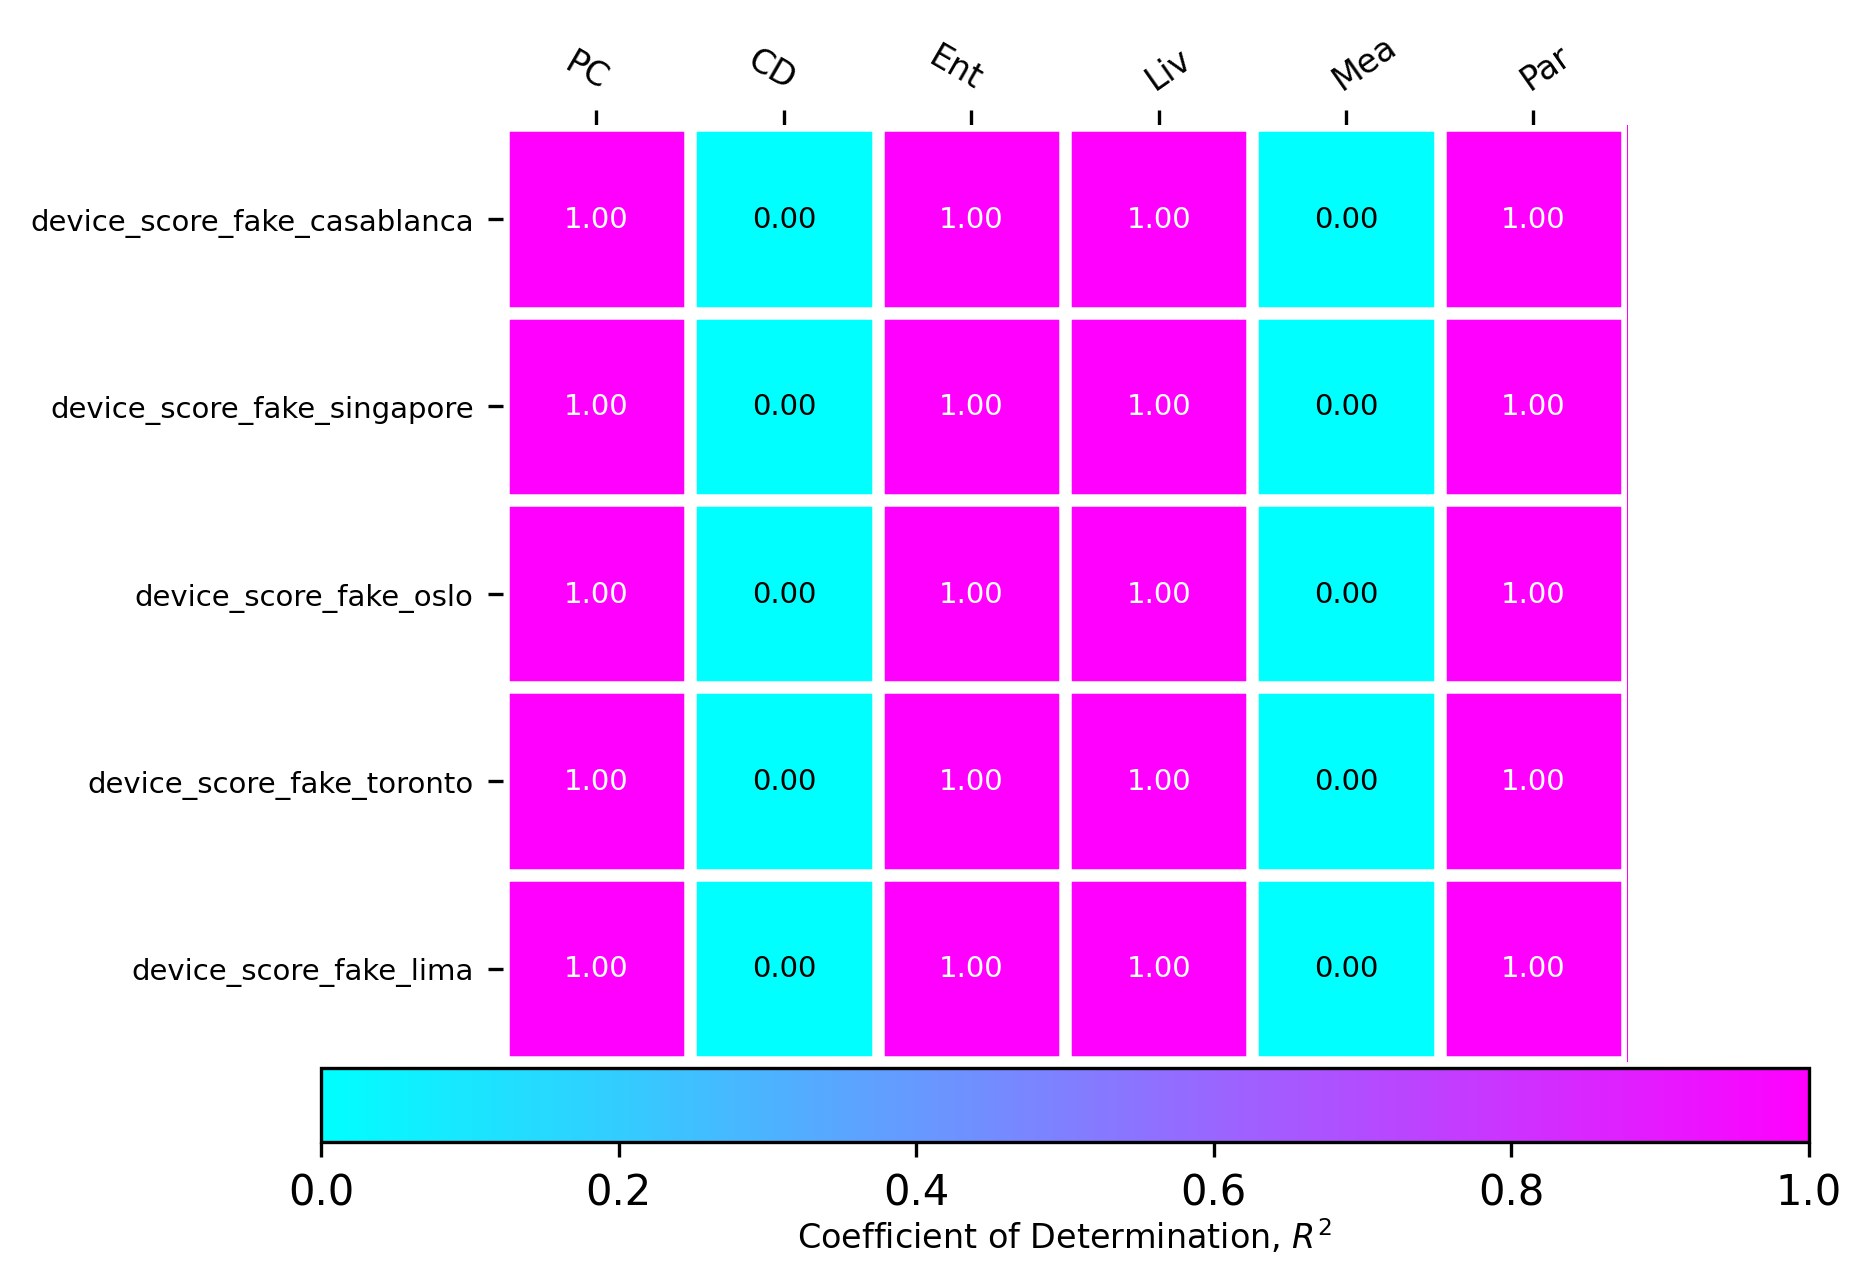

In [20]:
supermarq.plotting.plot_correlations(benchmark_features,all_fake_scores,["PC", "CD", "Ent", "Liv", "Mea", "Par"],device_name=all_fake_names,show=True,)

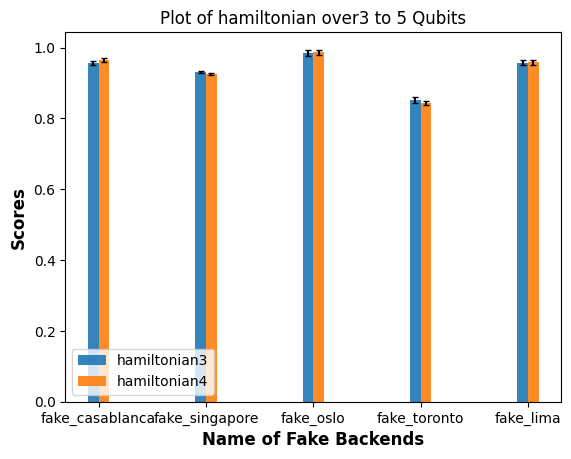

In [23]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import numpy as np
all_fake_names=[]
all_score=[]
all_sd=[]
all_ckt=[]
v='Plot of '+name_of_algo+' over'+str(lower_limit)+' to '+str(upper_limit)+ ' Qubits'
for i in selected_fakes:
    all_fake_names.append(i().name)    
for benchmark, label in benchmarks:
    i=[]
    j=[]
    k=[]
    for ckt,benchmark,backend,job,score,sd in jobs:
        if ckt == label:
            i.append(score)
            j.append(sd)
    all_ckt.append(label)
    all_score.append(i)
    all_sd.append(j)
num_bars = len(all_score)
width = 0.1
x = np.arange(len(all_fake_names)) # x-axis positions for each bar
fig, ax = plt.subplots()
for i in range(num_bars):               # Create bars for each category with appropriate offsets
    ax.bar(x + i * width, all_score[i], width=width, label=f'Bar {i+1}', 
           yerr=all_sd[i],align='center',alpha=0.9,ecolor='black',capsize=2)
ax.set_xlabel('Name of Fake Backends',fontweight ='bold',fontsize = 12)
ax.set_ylabel('Scores',fontweight ='bold',fontsize = 12)
ax.set_title(v)
ax.set_xticks(x + (num_bars - 1) * width / 2)
ax.set_xticklabels(all_fake_names)
ax.legend(all_ckt,loc="lower left")
#ax.grid(True)
plt.show()